In [1]:
import numpy as np
import scipy as sp
from numpy import linalg as nla
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

Model

In [2]:
k=0.4032
c=2.3952
p=0.3224
d=0.225423
def model(r,tc):
    x=r[0]
    y=r[1]
    z=r[2]
    a=7.3939+0.002*np.sin(1.8*tc)
    x1=1.0*(p*d*(x*x-a*x)+x*(x+y+c-c*np.tanh(x+z)))
    y1=-1.0*p*d*(a*y+x*x)
    z1=d*(k-z-0.5*x)
    return (np.array([x1,y1,z1]))

In [3]:
def jac(r,tc):
    x=r[0]
    y=r[1]
    z=r[2]
    M=np.array([[-c*np.tanh(x + z) + c + d*p*((-7.3939+0.002*np.sin(1.8*tc)) + 2*x) + x*(-c*(1 - np.tanh(x + z)**2) + 1) + x + y,x,-c*x*(1 - np.tanh(x + z)**2)],
                [-2*x*p*d,-p*d*(7.3939+0.002*np.sin(1.8*tc)),0],
                [-d*0.5,0,-d]])
    return M

In [4]:
def mul(r,tc,g):
    res=np.matmul(jac(r,tc),g)
    return res

Computations

In [5]:
%%time

g1=np.array([1,0,0])
tmax=500
h=0.001
t=0
x=-3
y=0
z=0
r=np.array([x,y,z])
talp=0
#talp2=0
#talp3=0
valt=[]
amp1=[]
#amp2=[]
#amp3=[]
valx=[]
#tr=[]

# Time loop
while (t<tmax):
    tc=t
    #xt=r[0]
    #yt=r[1]
    #zt=r[2]
    #Ma=jac(r,tc)
    #trace=Ma.trace()
    #tr.append(trace)
    
    #evolution of the perturbations along the Lyapunov directions
    l1=mul(r,tc,g1)
    l2=mul(r,tc,g1+0.5*h*l1)
    l3=mul(r,tc,g1+0.5*h*l2)
    l4=mul(r,tc,g1+h*l3)
    g1=g1+(1.0/6)*h*(l1+2*l2+2*l3+l4)
    
    # Gram-Schmittage
    #1er exposant
    norm=np.linalg.norm(g1)
    alp=np.log(norm)/h
    talp=talp+alp
    g1=g1/norm
    
    #2eme exposant
    #g2p=g2-g1*(np.dot(g2,g1))
    #norm2=np.linalg.norm(g2p)
    #alp2=np.log(norm2)/h
    #talp2=talp2+alp2
    #g2=g2p/norm2
    
    #3eme exposant
    #g3p=(g3-g2*(np.dot(g3,g2))-g1*(np.dot(g3,g1)))
    #norm3=np.linalg.norm(g3p)
    #alp3=np.log(norm3)/h
    #talp3=talp3+alp3
    #g3=g3p/norm3
    
    # Gathering the new directions into a matrix
    #g=np.hstack([g1[:,np.newaxis],g2[:,np.newaxis],g3[:,np.newaxis]])
    
    # Model time evolution
    #k1=model(r,tc)
    #k2=model(r+0.5*h*k1,tc)
    #k3=model(r+0.5*h*k2,tc)
    #k4=model(r+k3*h,tc)
    #r=r+(1.0/6)*h*(k1+2*k2+2*k3+k4)
    #t=t+h
    
    # Storing the results
    valt.append(t)
    amp1.append(alp)
    #amp3.append(alp3)
    valx.append(r[0])
print (talp/(tmax/h))
#print (talp2/(tmax/h))
#print (talp3/(tmax/h))
amp1=np.array(amp1)
#amp2=np.array(amp2)
#amp3=np.array(amp3)
valt=np.array(valt)
#tr=np.array(tr)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


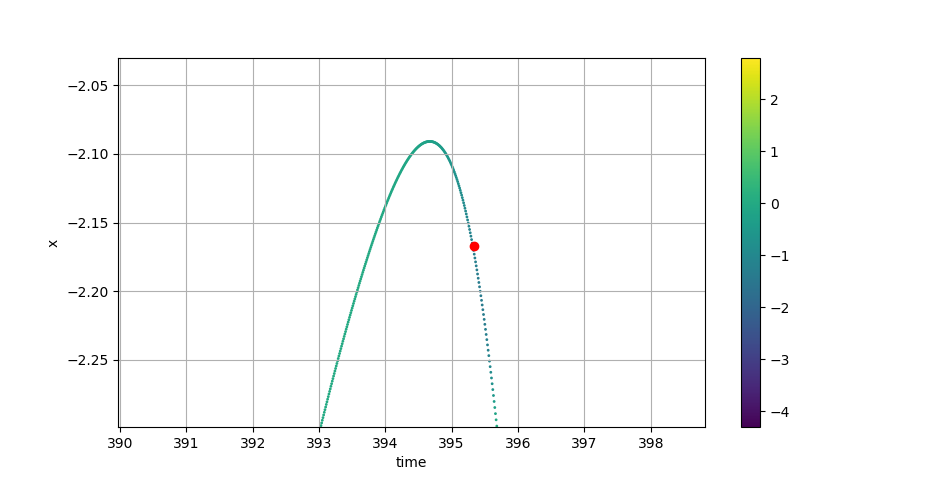

In [6]:
%matplotlib notebook
fig = plt.figure()
plt.xlabel('time')
plt.ylabel('x')
plot = plt.scatter(valt, valx, s= 1, c = amp1, cmap='viridis')
plt.plot(87.15, -2.463, 'ro')
plt.plot(156.62, -2.31435, 'ro')
plt.plot(209.82,-0.508301, 'ro')
plt.plot(211.81,-0.324628, 'ro')
plt.plot(215,-1.021,'ro')
plt.plot(386.69,-1.87748,'ro')
plt.plot(395.33,-2.16728,'ro')

fig.colorbar(plot)
plt.grid(True, 'both')
plt.show()

Plots

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.plot(valt, amp1+amp2+amp3, color=color, label='sum of exponent')

color = 'tab:red'
ax1.plot(valt, tr, color=color, label='trace')

plt.legend()
fig.tight_layout()  
plt.show()

In [ ]:
k=0.4032
c=2.3952
p=0.3224
delta=np.linspace(0.11,0.57,150)
def model(r,d,tc):
    x=r[0]
    y=r[1]
    z=r[2]
    a=7.3939+0.002*np.sin(1.8*tc)
    x1=1.0*(p*d*(x*x-a*x)+x*(x+y+c-c*np.tanh(x+z)))
    y1=-1.0*p*d*(a*y+x*x)
    z1=d*(k-z-0.5*x)
    return (np.array([x1,y1,z1]))

In [ ]:
def jac(r,d,tc):
    x=r[0]
    y=r[1]
    z=r[2]
    M=np.array([[-c*np.tanh(x + z) + c + d*p*((-7.3939+0.002*np.sin(1.8*tc)) + 2*x) + x*(-c*(1 - np.tanh(x + z)**2) + 1) + x + y,x,-c*x*(1 - np.tanh(x + z)**2)],
                [-2*x*p*d,-p*d*(7.3939+0.002*np.sin(1.8*tc)),0],
                [-d*0.5,0,-d]])
    return M

In [ ]:
def mul(r,d,tc,g):
    res=np.matmul(jac(r,d,tc),g)
    return res

In [ ]:
def integration():
    exp1=[]
    exp2=[]
    exp3=[]
    for i in delta:
        g=np.identity(3)
        tmax=800
        h=0.01
        t=0
        x=-3
        y=0
        z=0
        r=np.array([x,y,z])
        talp=0
        talp2=0
        talp3=0

        # Time loop
        while (t<tmax):
            tc=t
            xt=r[0]
            yt=r[1]
            zt=r[2]
    
            #evolution of the perturbations along the Lyapunov directions
            l1=mul(r,i,g)
            l2=mul(r,i,g+0.5*h*l1)
            l3=mul(r,i,g+0.5*h*l2)
            l4=mul(r,i,g+h*l3)
            g=g+(1.0/6)*h*(l1+2*l2+2*l3+l4)

            g1=g[:,0]
            g2=g[:,1]
            g3=g[:,2]

            # Gram-Schmittage
            #1er exposant
            norm=np.linalg.norm(g1)
            alp=np.log(norm)/h
            talp=talp+alp
            g1=g1/norm

            #2eme exposant
            g2p=g2-g1*(np.dot(g2,g1))
            norm2=np.linalg.norm(g2p)
            alp2=np.log(norm2)/h
            talp2=talp2+alp2
            g2=g2p/norm2

            #3eme exposant
            g3p=(g3-g2*(np.dot(g3,g2))-g1*(np.dot(g3,g1)))
            norm3=np.linalg.norm(g3p)
            alp3=np.log(norm3)/h
            talp3=talp3+alp3
            g3=g3p/norm3

            # Gathering the new directions into a matrix
            g=np.hstack([g1[:,np.newaxis],g2[:,np.newaxis],g3[:,np.newaxis]])

            # Model time evolution
            k1=model(r,i,tc)
            k2=model(r+0.5*h*k1,i,tc)
            k3=model(r+0.5*h*k2,i,tc)
            k4=model(r+k3*h,i,tc)
            r=r+(1.0/6)*h*(k1+2*k2+2*k3+k4)
            t=t+h

    # Storing the results
        
        l1=talp/tmax
        l2=talp2/tmax
        l3=talp3/tmax
        exp1.append(l1)
        exp2.append(l2)
        exp3.append(l3)
    return(exp1,exp2,exp3)

In [ ]:
results2=integration()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('$\delta$')
ax1.set_ylabel('exponent')
ax1.set_title('Lyapunov exponents as a function of $\delta$ with rho=0.3224 and zeta=1.3')
ax1.plot(delta, results2[0], color=color, label='exponent 1')

color = 'tab:orange'
ax1.set_xlabel('$\delta$')
ax1.plot(delta, results2[1], color=color, label='exponent 2')

plt.legend()
fig.tight_layout()  
plt.show()